In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded

In [25]:
N, K = 100, 100

In [26]:
def solve_explicit(a, max_t, max_x, phi0, phi1, psi):
    step_t = max_t / (N - 1)
    step_x = max_x / (K - 1)
    res = [psi(np.linspace(0, max_x, K))]

    for i in range(1, N):
        t = step_t * i
        layer = [phi0(t)]
        for j in range(1, K - 1):
            val = a * step_t / (step_x ** 2) * (res[-1][j + 1] - 2 * res[-1][j] + res[-1][j - 1]) + res[-1][j]
            layer.append(val)
        layer.append(phi1(t))
        res.append(layer)

    return np.array(res)

def solve_implicit(a, max_t, max_x, phi0, phi1, psi):
    step_t = max_t / (N - 1)
    step_x = max_x / (K - 1)
    delta = (a * step_t) / (step_x ** 2)

    res = [psi(np.linspace(0, max_x, K))]

    diagonals = np.zeros((3, K - 2))
    diagonals[0, 1:] = -delta
    diagonals[1, :] = 1 + 2 * delta
    diagonals[2, :-1] = -delta

    for i in range(1, N):
        t = step_t * i
        rhs = res[-1][1:-1]
        rhs[0] += delta * phi0(t)
        rhs[-1] += delta * phi1(t)
        layer_inner = solve_banded((1, 1), diagonals, rhs)

        layer = [phi0(t)] + list(layer_inner) + [phi1(t)]
        res.append(layer)

    return np.array(res)

def solve_crank_nicholson(a, max_t, max_x, phi0, phi1, psi):
    step_t = max_t / (N - 1)
    step_x = max_x / (K - 1)
    delta = 0.5 * a * step_t / (step_x ** 2)

    res = [psi(np.linspace(0, max_x, K))]

    diagonals = np.zeros((3, K - 2))
    diagonals[0, 1:] = -delta
    diagonals[1, :] = 1 + 2 * delta
    diagonals[2, :-1] = -delta

    for i in range(1, N):
        t = step_t * i
        prev_layer = np.array(res[-1])
        rhs_inner = (
            prev_layer[1:-1] - delta * (
                prev_layer[2:] - 2 * prev_layer[1:-1] + prev_layer[:-2]
            )
        )
        rhs_inner[0] += delta * phi0(t)
        rhs_inner[-1] += delta * phi1(t)
        layer_inner = solve_banded((1, 1), diagonals, rhs_inner)

        layer = [phi0(t)] + list(layer_inner) + [phi1(t)]
        res.append(layer)

    return np.array(res)

def mse(dim, max_t, max_x, f1, f2):
    step_t = max_t / (N - 1)
    step_x = max_x / (K - 1)

    errors = []
    for i in range(N if dim == 0 else K):
        cur_error = 0
        for j in range(K if dim == 0 else N):
            t, x = (step_t * i, step_x * j) if dim == 0 else (step_t * j, step_x * i)
            cur_error += (f1[i, j] - f2(x, t)) ** 2
        errors.append(cur_error / (K if dim == 0 else N))

    return lambda x: errors[min(int(x / (max_t if dim == 0 else max_x) * (N if dim == 0 else K)), len(errors) - 1)]

In [27]:
def phi0(t): return 0
def phi1(t): return 1
def psi(x): return x + np.sin(np.pi * x)
def analytic(x, t, a): return x + np.exp(-np.pi**2 * a * t) * np.sin(np.pi * x)

In [28]:
a = 0.01
max_t = 1
max_x = 1

In [29]:
x = np.linspace(0, max_x, K)
t = np.linspace(0, max_t, N)

explicit_res = solve_explicit(a, max_t, max_x, phi0, phi1, psi)
implicit_res = solve_implicit(a, max_t, max_x, phi0, phi1, psi)
crank_res = solve_crank_nicholson(a, max_t, max_x, phi0, phi1, psi)
analytic_res = np.array([[analytic(xi, ti, a) for xi in x] for ti in t])

explicit_error = np.sqrt(np.mean((explicit_res - analytic_res) ** 2, axis=1))
implicit_error = np.sqrt(np.mean((implicit_res - analytic_res) ** 2, axis=1))
crank_error = np.sqrt(np.mean((crank_res - analytic_res) ** 2, axis=1))

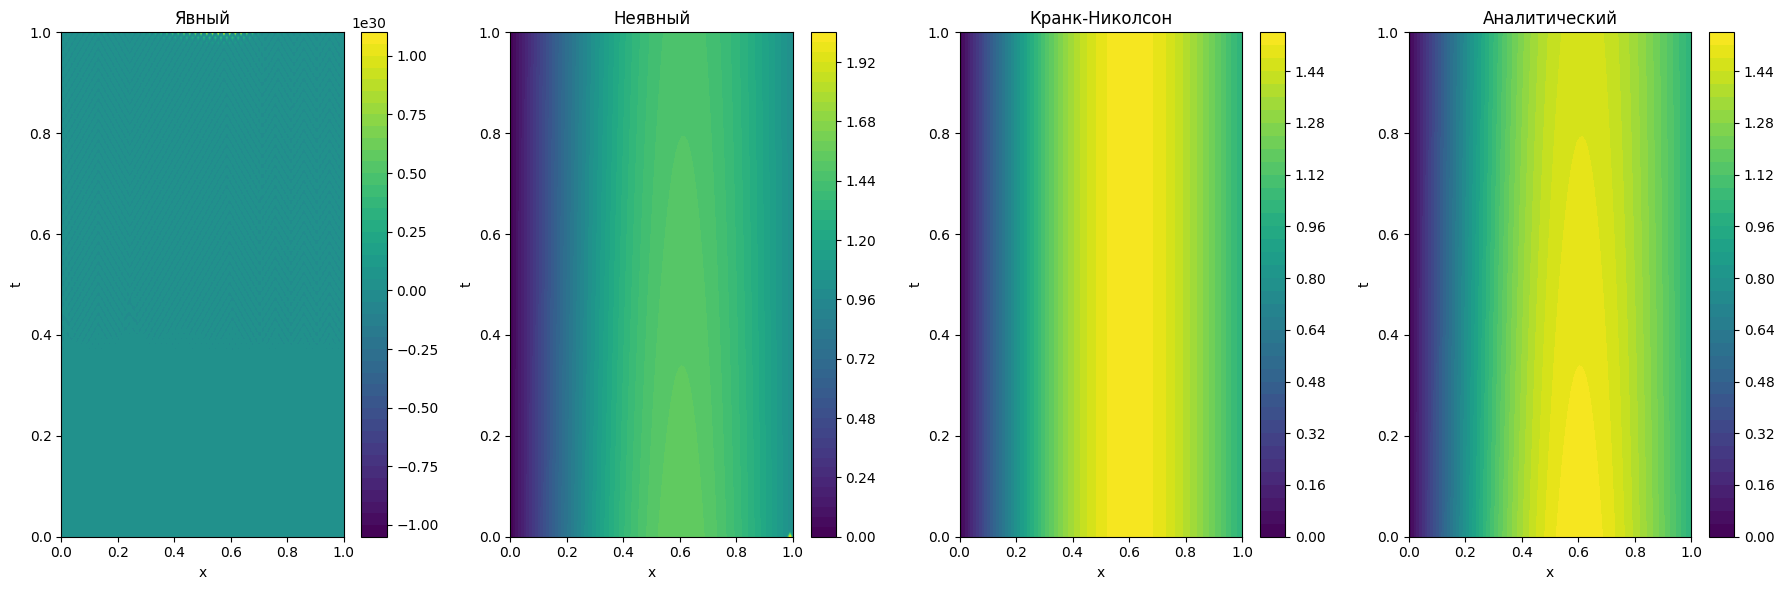

In [30]:
x = np.linspace(0, max_x, K)
t = np.linspace(0, max_t, N)
X, T = np.meshgrid(x, t)

fig, axes = plt.subplots(1, 4, figsize=(18, 6))
for ax, data, title in zip(axes, [explicit_res, implicit_res, crank_res, analytic_res], ["Явный", "Неявный", "Кранк-Николсон", "Аналитический"]):
    im = ax.contourf(X, T, data, 50, cmap="viridis")
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()


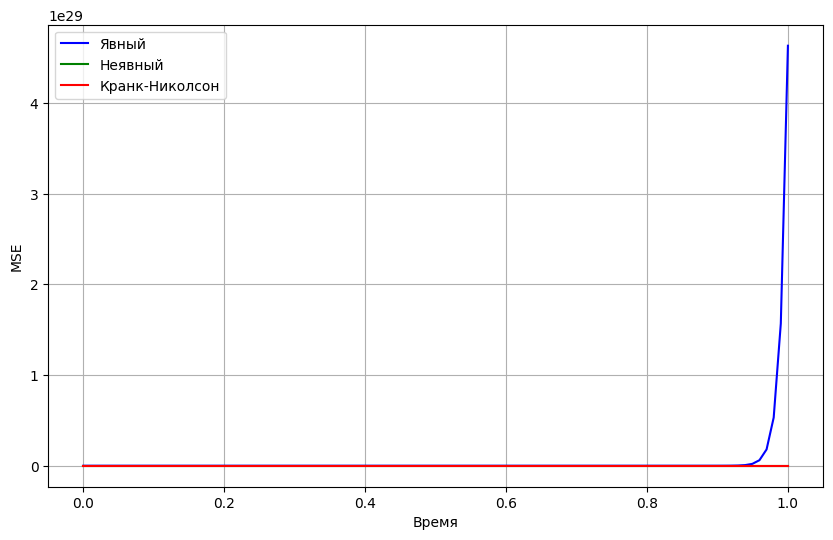

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(t, explicit_error, label="Явный", color='blue')
plt.plot(t, implicit_error, label="Неявный", color='green')
plt.plot(t, crank_error, label="Кранк-Николсон", color='red')

plt.xlabel("Время")
plt.ylabel("MSE")
plt.legend()
plt.grid()
plt.show()

- **Явный метод:** Быстро накапливает ошибку из-за условий устойчивости.
- **Неявный метод:** Более устойчивый, но менее точный, чем метод Кранка-Николсона.
- **Метод Кранка-Николсона:** Сочетает устойчивость и точность, что отражается на минимальных значениях ошибки.